# How to Generate Task Data?

**Goal**: By the end of this guide, you'll be able to generate task inputs for CANN simulations.

**Estimated Reading Time**: 10 minutes

---

## Introduction

CANN models need input stimuli to simulate realistic behaviors—tracking moving targets, encoding spatial positions, or responding to population-coded signals. Instead of manually creating these inputs, the **Task API** provides ready-to-use generators for common experimental paradigms.

This guide shows you how to:
1. Create a smooth tracking task
2. Generate task data
3. Understand the task data structure
4. Use task data in your simulations

## What are Tasks?

**Tasks** are objects that generate time-varying input stimuli for CANN models. They handle the complexity of:
- Creating biologically realistic input patterns
- Managing timing and duration
- Formatting data for efficient simulation loops
- Tracking metadata (e.g., target positions, velocities)

**Key principle**: Tasks **generate inputs** → Models **consume inputs** in simulation loops.

## Creating a Smooth Tracking Task

The most common task is **smooth tracking**, where a stimulus moves smoothly across the neural population:

In [1]:
import brainstate
from canns.models.basic import CANN1D
from canns.task.tracking import SmoothTracking1D
import jax

# Set up environment and model (from previous guide)
brainstate.environ.set(dt=0.1)
cann = CANN1D(num=512)
cann.init_state()

# Create a smooth tracking task
task = SmoothTracking1D(
    cann_instance=cann,                # Link to the CANN model
    Iext=(1.0, 0.75, 2.0, 1.75, 3.0),  # External input positions (in radians)
    duration=(10.0, 10.0, 10.0, 10.0), # Duration at each position (ms)
    time_step=brainstate.environ.get_dt()  # Simulation time step
)

**What's happening**:
- `cann_instance`: The task needs the model instance to access its `get_stimulus_by_pos()` method, which generates spatially-localized input patterns for given positions. The task also uses the model's structure (neuron positions, network size) to create appropriate stimuli.
- `Iext`: Sequence of target positions where the stimulus will appear (in radians, from -π to π)
- `duration`: How long the stimulus stays at each position (in milliseconds)
- `time_step`: Should match the model's `dt` for synchronization

**Important**: CANN models must provide a `get_stimulus_by_pos(position)` method that returns the input pattern for a given spatial position. This method is called by the task to generate data.

## Generating the Data

Once the task is created, generate the actual input arrays:

In [2]:
# Generate all task data
task.get_data()

<SmoothTracking1D> Generating Task data: 400it [00:00, 1770.89it/s]


This method pre-computes all input stimuli for the entire simulation. The data is stored in `task.data`.

## Understanding Task Data Structure

Let's inspect what the task generated:

In [3]:
print(f"Data shape: {task.data.shape}")
print(f"Number of time steps: {task.run_steps.shape[0]}")
print(f"Time step size: {task.time_step} ms")
print(f"Total simulation time: {task.run_steps.shape[0] * task.time_step} ms")

Data shape: (400, 512)
Number of time steps: 400
Time step size: 0.1 ms
Total simulation time: 40.0 ms


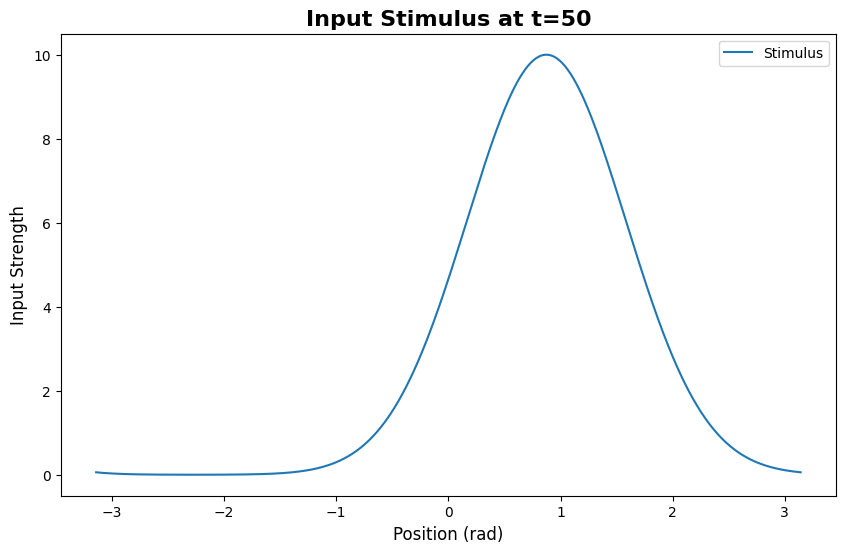

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Input Stimulus at t=50'}, xlabel='Position (rad)', ylabel='Input Strength'>)

In [4]:
from canns.analyzer.plotting import PlotConfigs, energy_landscape_1d_static

# Create configuration for static plot
config = PlotConfigs.energy_landscape_1d_static(
    time_steps_per_second=100,
    title='Input Stimulus at t=50',
    xlabel='Position (rad)',
    ylabel='Input Strength',
    show=True
)

# Plot input at time step 50
energy_landscape_1d_static(
    data_sets={'Stimulus': (cann.x, task.data[50])},
    config=config
)

You'll see a Gaussian-shaped bump centered at one of the `Iext` positions.

## Using Task Data in Simulations

Now connect the task data to your model simulation:

In [5]:
def run_step(t, stimulus):
    """Simulation step function."""
    cann(stimulus)  # Feed stimulus to model
    return cann.u.value, cann.r.value  # Return synaptic input and activity

# Run the simulation with task data
us, rs = brainstate.transform.for_loop(
    run_step,
    task.run_steps,  # Number of simulation steps
    task.data,       # Task-generated stimuli
    pbar=brainstate.transform.ProgressBar(10)
)

print(f"Synaptic input shape: {us.shape}")   # (400, 512)
print(f"Neural activity shape: {rs.shape}")  # (400, 512)

  0%|          | 0/400 [00:00<?, ?it/s]

Synaptic input shape: (400, 512)
Neural activity shape: (400, 512)


**The workflow**:
1. `task.data` provides stimuli for each time step
2. `for_loop` iterates through time steps
3. At each step, the stimulus is passed to `run_step`
4. The model updates its state and returns results
5. All results are collected into arrays (`us`, `rs`)

## Complete Working Example

Here's the full pipeline from model creation to task-driven simulation:

In [6]:
import brainstate
from canns.models.basic import CANN1D
from canns.task.tracking import SmoothTracking1D

# 1. Setup
brainstate.environ.set(dt=0.1)

# 2. Create model
cann = CANN1D(num=512)
cann.init_state()

# 3. Create task
task = SmoothTracking1D(
    cann_instance=cann,
    Iext=(1.0, 0.75, 2.0, 1.75, 3.0),
    duration=(10.0, 10.0, 10.0, 10.0),
    time_step=brainstate.environ.get_dt(),
)
task.get_data()

# 4. Run simulation
def run_step(t, stimulus):
    cann(stimulus)
    return cann.u.value, cann.r.value

us, rs = brainstate.transform.for_loop(
    run_step,
    task.run_steps,
    task.data,
    pbar=brainstate.transform.ProgressBar(10)
)

print("Simulation complete!")
print(f"Captured {us.shape[0]} time steps of activity")

<SmoothTracking1D> Generating Task data: 400it [00:00, 10705.97it/s]


  0%|          | 0/400 [00:00<?, ?it/s]

Simulation complete!
Captured 400 time steps of activity


## Exploring Task Parameters

`SmoothTracking1D` is flexible. Try different configurations:

### Example 1: Fast Tracking

In [7]:
task_fast = SmoothTracking1D(
    cann_instance=cann,
    Iext=(0.0, 1.0, 2.0),
    duration=(5.0, 5.0),  # Shorter durations = faster transitions
    time_step=0.1
)

### Example 2: Many Positions

In [8]:
import jax.numpy as jnp

# Track across 10 evenly spaced positions
positions = jnp.linspace(-3.0, 3.0, 10)
durations = [8.0] * 9

task_dense = SmoothTracking1D(
    cann_instance=cann,
    Iext=tuple(positions),
    duration=tuple(durations),
    time_step=0.1
)

### Example 3: Variable Durations

In [9]:
# Different durations for each position
task_variable = SmoothTracking1D(
    cann_instance=cann,
    Iext=(0.0, 1.5, -1.0, 2.0),
    duration=(15.0, 5.0, 10.0),  # Stay longer at first position
    time_step=0.1
)

## Other Task Types

While this guide focuses on `SmoothTracking1D`, the library includes other task generators:

- `SmoothTracking2D`: 2D spatial tracking
- `PopulationCoding`: Population-coded inputs
- `ClosedLoopNavigation`: Interactive navigation with feedback
- `OpenLoopNavigation`: Pre-defined trajectories

All follow the same pattern:
1. Create task with parameters
2. Call `task.get_data()`
3. Use `task.data` in simulation loops

We'll explore these in the Full Details section.

## Common Questions

**Q: Can I modify task data after generation?**

Yes! `task.data` is a JAX array you can manipulate:

In [10]:
task.get_data()
# Add noise to all inputs
task.data = task.data + 0.1 * jax.random.normal(jax.random.PRNGKey(0), task.data.shape)

<SmoothTracking1D> Generating Task data: 400it [00:00, 9121.57it/s]


**Q: What if I want custom input patterns?**

You can create tasks as templates and modify them, or generate inputs manually:

In [11]:
import jax.numpy as jnp

# Create custom input sequence
custom_data = jnp.zeros((100, 512))
for t in range(100):
    position = jnp.sin(t * 0.1)  # Sinusoidal movement
    custom_data = custom_data.at[t].set(
        jnp.exp(-0.5 * (cann.x - position)**2 / 0.3**2)
    )

**Q: Do I need to call `get_data()` every time?**

Only once per task instance. The data is cached:

In [ ]:
task.get_data()  # Generates data
# ... use task.data in simulations

# If you change parameters, recreate the task
task_new = SmoothTracking1D(...)
task_new.get_data()

## Next Steps

Now that you can generate task data, you're ready to:

1. **[Analyze CANN model dynamics](04_how_to_analyze_cann_model.md)** - Visualize energy landscapes, bump tracking, and more
2. **[Explore Task Generators](link-to-core-concepts-tasks)** - Learn about all available task types and their use cases
3. **[Full Task API Reference](link-to-full-details-tasks)** - Complete documentation of all task parameters and methods

---

**Quick Reference**:

In [ ]:
# Standard task workflow
from canns.task.tracking import SmoothTracking1D

task = SmoothTracking1D(
    cann_instance=cann,
    Iext=(pos1, pos2, ...),
    duration=(dur1, dur2, ...),
    time_step=dt
)
task.get_data()

# Use in simulation
for_loop(run_step, task.run_steps, task.data)

---

*Questions? Check the [Core Concepts: Task Generators](link) or [GitHub Discussions](https://github.com/routhleck/canns/discussions).*